In [1]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import gc
import numpy as np
sys.setrecursionlimit(100000)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib import path
import scipy.io as sio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import cmaps
import seapy

In [2]:

#define your observation, forward simulation and da simulation root path
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
mypriorroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
mypostroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
#define your workspace 
nl_workspace = 'outputs_201205/'
prior_workspace = 'workspace_sstbgqc/'
post_workspace = 'workspace_withcruise/'
obs_workspace = ''
#define your filenames
obs_file='sst_withcruiseptpkodc_2012_offshore.nc'
nl_files = "ocean_ecs_his_00*.nc"
#since this is a vertical profile validation, full fwd file is needed
prior_files = "STORAGE/posterior/ocean_ecs_fwd_*.nc"
posterior_files = "STORAGE/posterior/ocean_ecs_fwd_*.nc"

#
grd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'

In [3]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2013-04-08-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 6
# 2d situation
model_var = 'temp' 
#3d situation
# model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))




duration to be validated: from 2012-05-01-12H to 2013-04-08-12H, total of 343 days.
         target obs variable: 6
         target model variable: temp


In [4]:
# loading observation data
# differ from sst data
# cruise data are extracted from observation file in 4dvar format
# so the extract process is difference
Obs_ds = xr.open_dataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                          )


In [49]:
obs_all_provenance = Obs_ds.obs_provenance.data[:]
obs_all_time = Obs_ds.obs_time.data[:]

In [6]:
obs_all_timestamp = np.array([ dt.timedelta(itime) + dt.datetime(1970,1,1) for itime in obs_all_time])


In [5]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 200)&
                                (Obs_ds.obs_type == obs_var)
                        )

Obs_ds_thisrange = Obs_ds.isel(datum=this_range[0]).copy()
Obs_time = Obs_ds_thisrange.obs_time.data[:]
Obs_data = Obs_ds_thisrange.obs_value.data[:]
Obs_depth = Obs_ds_thisrange.obs_depth.data[:]
Obs_lon = Obs_ds_thisrange.obs_lon.data[:]
Obs_lat = Obs_ds_thisrange.obs_lat.data[:]
Obs_x = Obs_ds_thisrange.obs_Xgrid.data[:]
Obs_y = Obs_ds_thisrange.obs_Ygrid.data[:]
# Obs_data = Obs_data
# Obs_data


In [6]:
# loading forward sst
start = time.time()
fwd_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 8.820996 min


In [7]:
fwd_time = fwd_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [25]:
mydaroot+prior_workspace+prior_files

'/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_withcruise/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'

In [8]:
# loading prior sst
start = time.time()
prior_ds = xr.open_mfdataset(mypriorroot+prior_workspace+prior_files,
                             engine='netcdf4',coords='minimal',
                             parallel=True,
                             # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                             #             # 's_rho':z_chunk, # only 3d needed
                             #               'eta_u':y_chunk,'xi_u':x_chunk,\
                             #               'eta_v':y_chunk,'xi_v':x_chunk,\
                             #               'eta_psi':y_chunk,'xi_psi':x_chunk,},
                            )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))



loading costing 3.624433 min


In [9]:
prior_time = prior_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [10]:
# loading poseterior sst
start = time.time()
post_ds = xr.open_mfdataset(mypostroot+post_workspace+posterior_files,
                                 engine='netcdf4',coords='minimal',
                                 parallel=True,
                                 # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                 #         # 's_rho':z_chunk, # only 3d needed
                                 #           'eta_u':y_chunk,'xi_u':x_chunk,\
                                 #           'eta_v':y_chunk,'xi_v':x_chunk,\
                                 #           'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                )#.chunk(dict(ocean_time=-1))

end = time.time()
print('loading costing %f min'%((end-start)/60))



loading costing 3.522330 min


In [11]:
post_time = post_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [16]:
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


In [11]:

ip = 0
for iobstime in np.unique(Obs_time):
    thistime = np.where(Obs_time == iobstime)
    
    
   
    for ipos in np.array(list(set(tuple(zip(np.round(Obs_lon[thistime],8),np.round(Obs_lat[thistime],8)))))):
        # print(ipos)
        thispos = np.where( (np.round(Obs_lon[thistime],8)==ipos[0]) & (np.round(Obs_lat[thistime],8)==ipos[1]))
    
    
        obs_profile = Obs_data[thistime][thispos]
        x_thispos = int(np.round(Obs_x[thistime][thispos][0]))
        lon_thispos = ipos[0]
        # print(x_thispos,lon_thispos)
        y_thispos = int(np.round(Obs_y[thistime][thispos][0]))
        lat_thispos = ipos[1]
        # print(y_thispos,lat_thispos)
        if ip == 0:
            lon_obs = ipos[0]
            lat_obs = ipos[1]
        else:
            lon_obs = np.r_[lon_obs,ipos[0]]
            lat_obs = np.c_[lat_obs,ipos[1]]
        ip+=1

In [17]:
my_palette = sns.color_palette(my_div_color[5:-5])

In [25]:
plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
my_palette = sns.color_palette(my_div_color[5:-5])
ip = 0
for iobstime in np.unique(Obs_time):
    thistime = np.where(Obs_time == iobstime)
    print('OBS TIME:',(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    fwd_tindex = np.argmin(np.abs(fwd_time-iobstime))
    da_tindex = np.argmin(np.abs(prior_time-iobstime))
    
    fwddata_thistime = fwd_ds[model_var].isel(ocean_time=fwd_tindex).data.compute()
    print('FWD TIME:',(dt.timedelta(fwd_time[fwd_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    fwdzeta_thistime = fwd_ds['zeta'].isel(ocean_time=fwd_tindex).data.compute()
    
    
    priordata_thistime = prior_ds[model_var].isel(ocean_time=da_tindex).data.compute()
    priorzeta_thistime = fwd_ds['zeta'].isel(ocean_time=da_tindex).data.compute()
    
    print('DA TIME:',(dt.timedelta(prior_time[da_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
    postdata_thistime = post_ds[model_var].isel(ocean_time=da_tindex).data.compute()
    postzeta_thistime = post_ds['zeta'].isel(ocean_time=da_tindex).data.compute()
    
    fwdgrid = seapy.model.asgrid(grd_file); fwdgrid.zeta = fwdzeta_thistime;fwdgrid = seapy.model.asgrid(fwdgrid)
    priorgrid = seapy.model.asgrid(grd_file); priorgrid.zeta = priorzeta_thistime;priorgrid = seapy.model.asgrid(priorgrid)
    postgrid = seapy.model.asgrid(grd_file); postgrid.zeta = postzeta_thistime;postgrid = seapy.model.asgrid(postgrid)
    
    for ipos in np.array(list(set(tuple(zip(np.round(Obs_lon[thistime],8),np.round(Obs_lat[thistime],8)))))):
        print(ipos)
        thispos = np.where( (np.round(Obs_lon[thistime],8)==ipos[0]) & (np.round(Obs_lat[thistime],8)==ipos[1]))
    
    
        obs_profile = Obs_data[thistime][thispos]
        x_thispos = int(np.round(Obs_x[thistime][thispos][0]))
        lon_thispos = ipos[0]
        # print(x_thispos,lon_thispos)
        y_thispos = int(np.round(Obs_y[thistime][thispos][0]))
        lat_thispos = ipos[1]
        # print(y_thispos,lat_thispos)
        depth_intplevel = np.arange(-200,1,1)
        obs_intplevel = np.interp(depth_intplevel,Obs_depth[thistime][thispos],obs_profile,left=np.nan,right=np.nan)
        
        print('\tOBS POS:', 'LON:', lon_thispos, 'LAT:', lat_thispos)
    
        print('\tMOD POS:', 'LON:',fwd_ds.lon_rho.data.compute()[y_thispos,x_thispos],
                          'LAT:',fwd_ds.lat_rho.data.compute()[y_thispos,x_thispos])
        print('\tMOD POS:', 'X:  ', x_thispos, 'Y:  ', y_thispos)
    

        fwd_intplevel = np.interp(depth_intplevel,fwdgrid.depth_rho[:,y_thispos,x_thispos],fwddata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        prior_intplevel = np.interp(depth_intplevel,priorgrid.depth_rho[:,y_thispos,x_thispos],priordata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        post_intplevel = np.interp(depth_intplevel,postgrid.depth_rho[:,y_thispos,x_thispos],postdata_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
        if ip == 0:
            Obs_profiles = obs_intplevel.copy()
            Fwd_profiles = fwd_intplevel.copy()
            Prior_profiles = prior_intplevel.copy()
            Post_profiles = post_intplevel.copy()
            Fwd_errs = fwd_intplevel - obs_intplevel
            Prior_errs = prior_intplevel - obs_intplevel
            Post_errs = post_intplevel - obs_intplevel
        else:
            Obs_profiles = np.c_[Obs_profiles,obs_intplevel.copy()]
            Fwd_profiles = np.c_[Fwd_profiles,fwd_intplevel.copy()]
            Prior_profiles = np.c_[Prior_profiles,prior_intplevel.copy()]
            Post_profiles = np.c_[Post_profiles,post_intplevel.copy()]
            Fwd_errs = np.c_[Fwd_errs,fwd_intplevel - obs_intplevel]
            Prior_errs = np.c_[Prior_errs,prior_intplevel - obs_intplevel]
            Post_errs = np.c_[Post_errs,post_intplevel - obs_intplevel]
        
        ip+=1
            
#         fig,ax = plt.subplots(figsize = (4,8))
    
#         ax.plot(obs_profile,Obs_depth[thistime][thispos],'o-',color='k',label='cruise obs')
#         # ax.plot(fwd_profile[1:],depth_modlevel[1:],color=my_palette[-1], label='forward',)
#         ax.plot(fwd_intplevel,depth_intplevel,'.-',color=my_palette[0], label='forward',)
    
    
#         # ax.plot(prior_profile[1:],depth_modlevel[1:],color=my_palette[7],label='prior',)
#         # ax.plot(prior_intplevel,depth_intplevel,'.-',color=my_palette[7],label='DA_SST ROMSv4.1',)
#         # ax.plot(post_profile[1:],depth_modlevel[1:],color=my_palette[0],label='posterior',)
#         # ax.plot(post_intplevel,depth_intplevel,'.-',color=my_palette[-1],label='DA_ALL ROMSv4.1',)
#         ax.legend(loc='upper left',fontsize=12)
#         ax.set_ylabel('depth/m')
#         ax.set_xlabel('temp/$\degree$C')
#         ax.set_title('OBS TIME = %s \n LON: %s LAT: %s'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'),
#                                                 np.round(lon_thispos,2),
#                                                 np.round(lat_thispos,2)))
#         plt.savefig('./fig_profile_fwd/%s_profile.jpeg'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H_%M')),bbox_inches='tight',dpi=400)
#         plt.close()
    del fwddata_thistime
    del fwdzeta_thistime
    del priordata_thistime
    del priorzeta_thistime
    del postdata_thistime
    del postzeta_thistime
    del fwdgrid
    del priorgrid
    del postgrid
    gc.collect()

OBS TIME: 2012-05-02 07:48
FWD TIME: 2012-05-02 08:00
DA TIME: 2012-05-02 08:00
[122.42458803  31.27411899]
	OBS POS: LON: 122.42458803 LAT: 31.27411899
	MOD POS: LON: 122.41741821107213 LAT: 31.28632052937131
	MOD POS: X:   67 Y:   153
OBS TIME: 2012-05-02 12:43
FWD TIME: 2012-05-02 13:00
DA TIME: 2012-05-02 13:00
[123.09839872  31.2746042 ]
	OBS POS: LON: 123.09839872 LAT: 31.2746042
	MOD POS: LON: 123.0914767700736 LAT: 31.27314190226044
	MOD POS: X:   85 Y:   152
OBS TIME: 2012-05-02 18:12
FWD TIME: 2012-05-02 18:00
DA TIME: 2012-05-02 18:00
[123.90987608  31.27714609]
	OBS POS: LON: 123.90987608 LAT: 31.27714609
	MOD POS: LON: 123.92036342698968 LAT: 31.26937526712205
	MOD POS: X:   106 Y:   151
OBS TIME: 2012-05-02 22:11
FWD TIME: 2012-05-02 22:00
DA TIME: 2012-05-02 22:00
[124.54787516  31.27392369]
	OBS POS: LON: 124.54787516 LAT: 31.27392369
	MOD POS: LON: 124.53588998041961 LAT: 31.263069991196048
	MOD POS: X:   121 Y:   150
OBS TIME: 2012-05-03 02:40
FWD TIME: 2012-05-03 03:

IndexError: index 8221 is out of bounds for axis 0 with size 8176

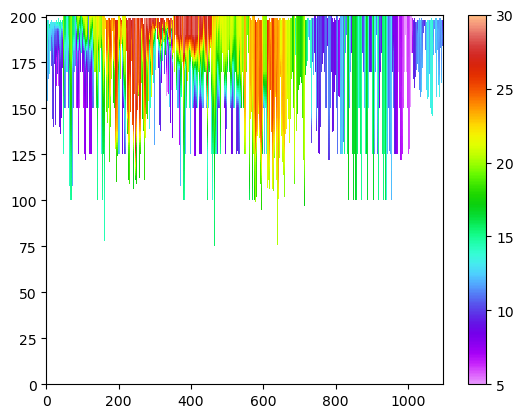

In [37]:
plt.style.use('default')
plt.pcolormesh(Obs_profiles,cmap=cmaps.NCV_bright,vmin=5,vmax=30)
plt.colorbar()

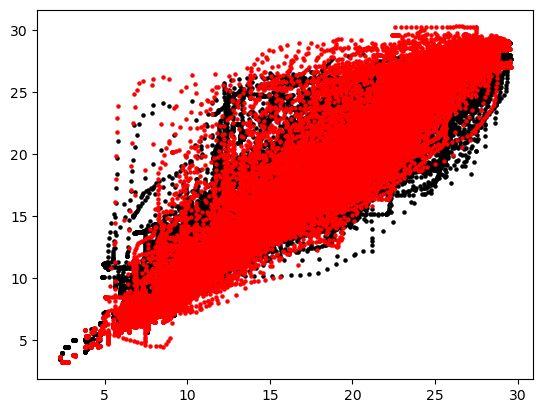

In [58]:

plt.scatter(Obs_profiles.ravel(),Fwd_profiles.ravel(),5,'k')
# plt.colorbar()
plt.scatter(Obs_profiles.ravel(),Post_profiles.ravel(),5,'r',)

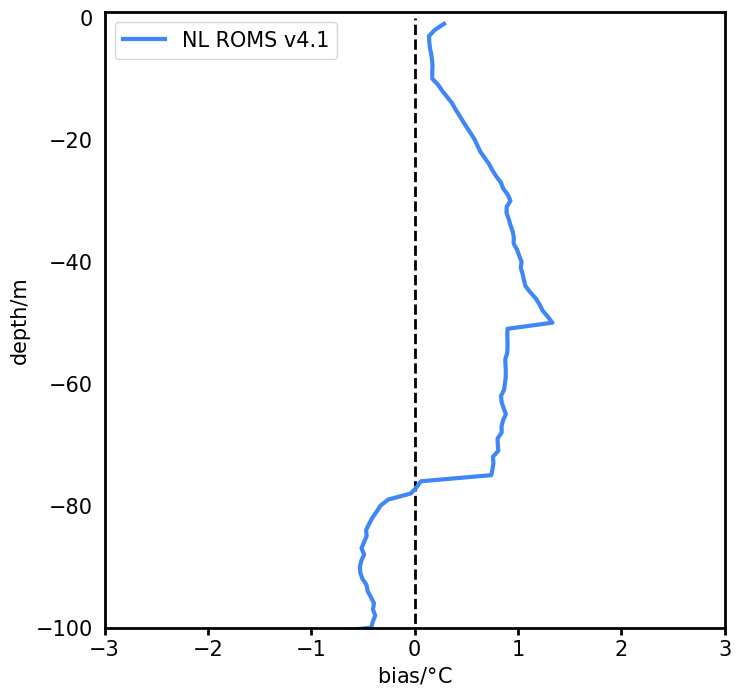

In [51]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (8,8))
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.plot(np.nanmean(Fwd_errs,axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='NL ROMS v4.1',zorder=2)
# ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
# ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
ax.plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
ax.set_xlim([-3,3])
ax.set_ylim([-100,1])
ax.legend(loc='upper left',fontsize=15)
ax.set_ylabel('depth/m',fontsize=15)
ax.set_xlabel('bias/$\degree$C',fontsize=15)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
# plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)

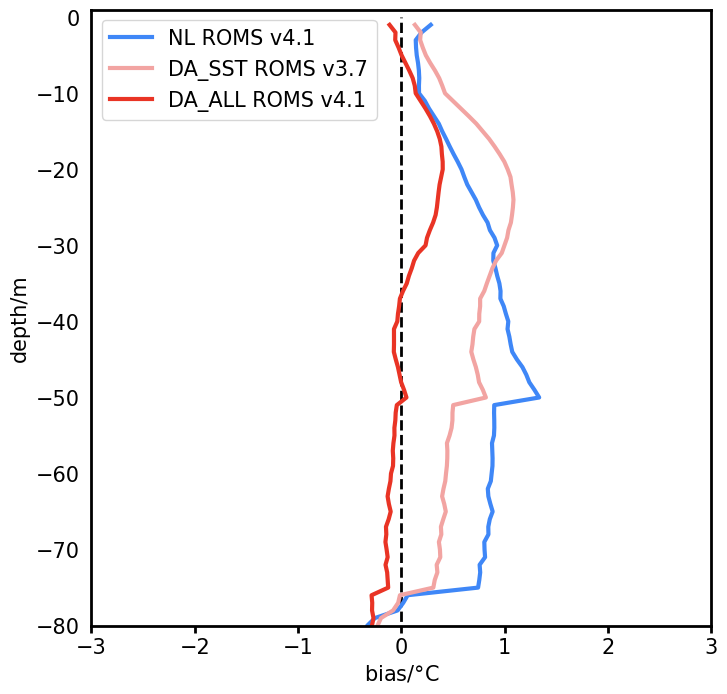

In [53]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (8,8))
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.plot(np.nanmean(Fwd_errs,axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='NL ROMS v4.1',zorder=2)
ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
ax.plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
ax.set_xlim([-3,3])
ax.set_ylim([-80,1])
ax.legend(loc='upper left',fontsize=15)
ax.set_ylabel('depth/m',fontsize=15)
ax.set_xlabel('bias/$\degree$C',fontsize=15)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
# plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)

In [25]:
bath_ecs = fwd_ds.h.isel(ocean_time=1).data.compute()
mask_ecs = fwd_ds.mask_rho.isel(ocean_time=1).data.compute()
bath_ecs[mask_ecs == 0] = np.NaN
lon_ecs =fwd_ds.lon_rho.data.compute()
lat_ecs = fwd_ds.lat_rho.data.compute()

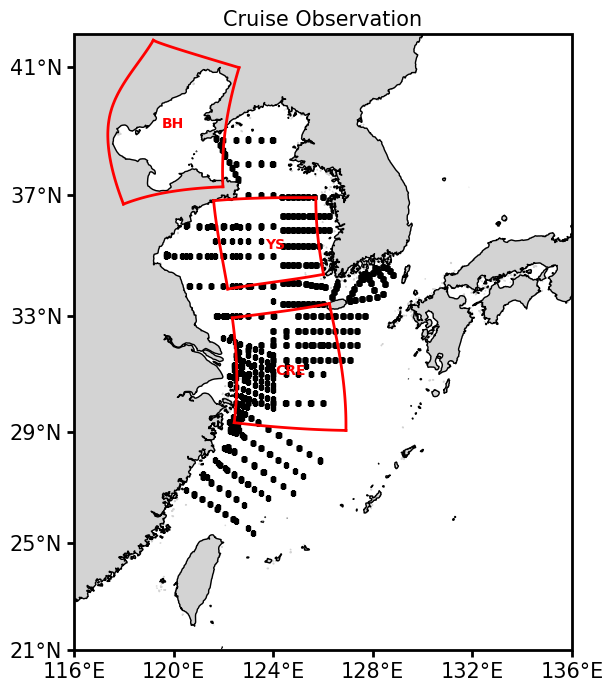

In [90]:
# %matplotlib

plt.style.use('default')
lon_bdy = [116,136];
lat_bdy = [21,42];
plt.rcParams['font.family'] = 'sans-serif'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'k',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.scatter(lon_obs,lat_obs.ravel(),10,'k',marker='s',transform = ccrs.PlateCarree(),)
for iarea in ['bh','cre','ys']:
    if iarea == 'bh':
        abbrname = 'BH'
    elif iarea == 'ys':
        abbrname = 'YS'
    elif iarea =='cre':
        abbrname = 'CRE'
    lon_area = fwd_ds.lon_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).data.compute()
    lat_area = fwd_ds.lat_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).data.compute()

    ax.plot(lon_area[:,0], lat_area[:,0], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[:,-1], lat_area[:,-1], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[-1,:], lat_area[-1,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[0,:], lat_area[0,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.text(0.5*(lon_area[0,0]+lon_area[0,-1]),
            0.5*(lat_area[0,0]+lat_area[-1,0]),abbrname, 
            verticalalignment='center', horizontalalignment='center',
            color = 'r',fontweight='bold',
            transform=ccrs.PlateCarree(),zorder = 3)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0)
ax.set_title('Cruise Observation',fontsize=15)
plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/obs_pos.jpeg',bbox_inches='tight',dpi=400)

In [422]:
np.minimum(obs_depth[thistime][thispos])

NameError: name 'obs_depth' is not defined

In [12]:
def ll_unique(obs_time,obs_lon,obs_lat,obs_data):
    ip = 0
    for iobstime in np.unique(obs_time):
        thistime = np.where(obs_time == iobstime)



        for ipos in np.array(list(set(tuple(zip(np.round(obs_lon[thistime],8),np.round(obs_lat[thistime],8)))))):
            # print(ipos)
            thispos = np.where( (np.round(obs_lon[thistime],8)==ipos[0]) & (np.round(obs_lat[thistime],8)==ipos[1]))


            obs_profile = obs_data[thistime][thispos]

            lon_thispos = ipos[0]

            lat_thispos = ipos[1]
            if ip == 0:
                lon_obs = ipos[0]
                lat_obs = ipos[1]
            else:
                lon_obs = np.r_[lon_obs,ipos[0]]
                lat_obs = np.c_[lat_obs,ipos[1]]
            ip+=1
    return lon_obs, lat_obs

def obs_intp2mod(grd_file,dataset,ds_time,obs_data,obs_time,obs_lon,obs_lat,obs_x,obs_y,obs_depth,figpath):
    ip = 0
    for iobstime in np.unique(obs_time):
        thistime = np.where(obs_time == iobstime)
        # print('OBS TIME:',(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
        ds_tindex = np.argmin(np.abs(ds_time-iobstime))
        # da_tindex = np.argmin(np.abs(prior_time-iobstime))

        data_thistime = dataset[model_var].isel(ocean_time=ds_tindex).data.compute()
        # print('dataset TIME:',(dt.timedelta(ds_time[ds_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
        zeta_thistime = dataset['zeta'].isel(ocean_time=ds_tindex).data.compute()



        grid = seapy.model.asgrid(grd_file); grid.zeta = zeta_thistime;grid = seapy.model.asgrid(grid)
    #     priorgrid = seapy.model.asgrid(grd_file); priorgrid.zeta = priorzeta_thistime;priorgrid = seapy.model.asgrid(priorgrid)
    #     postgrid = seapy.model.asgrid(grd_file); postgrid.zeta = postzeta_thistime;postgrid = seapy.model.asgrid(postgrid)

        for ipos in np.array(list(set(tuple(zip(np.round(obs_lon[thistime],8),np.round(obs_lat[thistime],8)))))):
            # print(ipos)
            thispos = np.where( (np.round(obs_lon[thistime],8)==ipos[0]) & (np.round(obs_lat[thistime],8)==ipos[1]))


            obs_profile =obs_data[thistime][thispos]
            x_thispos = int(np.round(obs_x[thistime][thispos][0]))
            lon_thispos = ipos[0]
            # print(x_thispos,lon_thispos)
            y_thispos = int(np.round(obs_y[thistime][thispos][0]))
            lat_thispos = ipos[1]
            # print(y_thispos,lat_thispos)
            depth_intplevel = np.arange(-200,1,1)
            obs_intplevel = np.interp(depth_intplevel,obs_depth[thistime][thispos],obs_profile,left=np.nan,right=np.nan)

            # print('\tOBS POS:', 'LON:', lon_thispos, 'LAT:', lat_thispos)

            # print('\tMOD POS:', 'LON:',dataset.lon_rho.data.compute()[y_thispos,x_thispos],
                              # 'LAT:',dataset.lat_rho.data.compute()[y_thispos,x_thispos])
            # print('\tMOD POS:', 'X:  ', x_thispos, 'Y:  ', y_thispos)


            data_intplevel = np.interp(depth_intplevel,grid.depth_rho[:,y_thispos,x_thispos],data_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
            obs_intplevel[depth_intplevel<np.maximum(np.nanmin(obs_depth[thistime][thispos]), np.nanmin(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            data_intplevel[depth_intplevel<np.maximum(np.nanmin(obs_depth[thistime][thispos]), np.nanmin(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            obs_intplevel[depth_intplevel>np.minimum(np.nanmax(obs_depth[thistime][thispos]), np.nanmax(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            data_intplevel[depth_intplevel>np.minimum(np.nanmax(obs_depth[thistime][thispos]), np.nanmax(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            if ip == 0:
                obs_profiles = obs_intplevel.copy()
                data_profiles = data_intplevel.copy()

                data_errs = data_intplevel - obs_intplevel

            else:
                obs_profiles = np.c_[obs_profiles,obs_intplevel.copy()]
                data_profiles = np.c_[data_profiles,data_intplevel.copy()]

                data_errs = np.c_[data_errs,data_intplevel - obs_intplevel]


            ip+=1
            fig,ax = plt.subplots(figsize = (4,8))
    
            ax.plot(obs_profile,obs_depth[thistime][thispos],'o-',color='k',label='cruise obs')
            # ax.plot(fwd_profile[1:],depth_modlevel[1:],color=my_palette[-1], label='forward',)
            ax.plot(data_intplevel,depth_intplevel,'.-',color=my_palette[0], label='mod',)


            # ax.plot(prior_profile[1:],depth_modlevel[1:],color=my_palette[7],label='prior',)
            # ax.plot(prior_intplevel,depth_intplevel,'.-',color=my_palette[7],label='DA_SST ROMSv4.1',)
            # ax.plot(post_profile[1:],depth_modlevel[1:],color=my_palette[0],label='posterior',)
            # ax.plot(post_intplevel,depth_intplevel,'.-',color=my_palette[-1],label='DA_ALL ROMSv4.1',)
            ax.legend(loc='upper left',fontsize=12)
            ax.set_ylabel('depth/m')
            ax.set_xlabel('temp/$\degree$C')
            ax.set_title('OBS TIME = %s \n LON: %s LAT: %s'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'),
                                                    np.round(lon_thispos,2),
                                                    np.round(lat_thispos,2)))
            plt.savefig('./%s/%s_profile.jpeg'%(figpath,(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H_%M')),bbox_inches='tight',dpi=400)
        plt.close()
        del data_thistime
        del zeta_thistime

        del grid
        gc.collect()
        
    return obs_profiles, data_profiles, data_errs

In [13]:
# area specific validatoin
area_range = {'bh':{'eta_range':slice(285,360),
                      'xi_range':slice(0,80)},
              
              'ys':{'eta_range': slice(220,278),
                    'xi_range':slice(70,165)},
              
              'cre':{'eta_range':slice(100,200),
                     'xi_range':slice(70,165)},
             }
profile_set = {}
season = ['MAM', 'JJA', 'SON','DJF',]
for iarea in ['ys','cre']:
    for i, iseason in enumerate(season):
    # i=1
        if i==0:
            profile_set[iarea]={}
        profile_set[iarea][iseason]={}
    


In [513]:
profile_set['ys'].keys()

dict_keys(['MAM'])

In [21]:
for iarea in ['ys','cre']:
    # iarea = 'ys'
    print('area: %s'%(iarea))
    lon_rho_area = fwd_ds.lon_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                     xi_rho=area_range[iarea]['xi_range']).data.compute()
    lat_rho_area = fwd_ds.lat_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                     xi_rho=area_range[iarea]['xi_range']).data.compute()

    Xbox_area = np.r_[lon_rho_area[0,:],
                 lon_rho_area[1:,-1],
                 np.flip(lon_rho_area[-1,:-1]),
                 np.flip(lon_rho_area[:-1,0])]
    Ybox_area = np.r_[lat_rho_area[0,:],
                 lat_rho_area[1:,-1],
                 np.flip(lat_rho_area[-1,:-1]),
                 np.flip(lat_rho_area[:-1,0])]
    box_area = [(x,y) for x,y in zip(Xbox_area,Ybox_area)]
    polygon = path.Path(box_area)
    withinarea = polygon.contains_points([(obsx,obsy) for obsx,obsy in zip(Obs_lon,Obs_lat)])
    index_area = np.where(withinarea)
    Obs_ds_area = Obs_ds_thisrange.isel(datum=withinarea)

    Obs_ds_area =Obs_ds_area.assign_coords(datum=[ dt.timedelta(itime)+dt.datetime(1970,1,1) for itime in Obs_ds_area.obs_time.data ])

    Obs_ds_as = Obs_ds_area.groupby('datum.season') # as: area season 
    season = ['MAM',  'JJA', 'SON','DJF',]
    for i, iseason in enumerate(season):
        print('season: %s'%(iseason))
        Obs_time_tats = Obs_ds_as[iseason].obs_time.data[:]  # tats :this area this season 
        Obs_data_tats = Obs_ds_as[iseason].obs_value.data[:]
        Obs_depth_tats = Obs_ds_as[iseason].obs_depth.data[:]
        Obs_lon_tats = Obs_ds_as[iseason].obs_lon.data[:]
        Obs_lat_tats = Obs_ds_as[iseason].obs_lat.data[:]
        Obs_x_tats = Obs_ds_as[iseason].obs_Xgrid.data[:]
        Obs_y_tats = Obs_ds_as[iseason].obs_Ygrid.data[:]


        lon_obs_tats, lat_obs_tats = ll_unique(Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_data_tats)

        obs_profile_tats, fwd_profile_tats, fwd_err_tats = obs_intp2mod(grd_file,fwd_ds,fwd_time,
                                                                       Obs_data_tats,Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_x_tats, Obs_y_tats, Obs_depth_tats,
                                                                       'fig_profile_fwd/%s/%s'%(iarea,iseason))
        obs_profile_tats, prior_profile_tats, prior_err_tats = obs_intp2mod(grd_file,prior_ds,post_time,
                                                                       Obs_data_tats,Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_x_tats, Obs_y_tats, Obs_depth_tats,
                                                                       'fig_profile_prior/%s/%s'%(iarea,iseason))

        obs_profile_tats, post_profile_tats, post_err_tats = obs_intp2mod(grd_file,post_ds,post_time,
                                                                       Obs_data_tats,Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_x_tats, Obs_y_tats, Obs_depth_tats,
                                                                       'fig_profile_post/%s/%s'%(iarea,iseason))
        profile_set[iarea][iseason]['lon_obs'] = lon_obs_tats
        profile_set[iarea][iseason]['lon_obs'] = lat_obs_tats
        profile_set[iarea][iseason]['obs'] = obs_profile_tats
        profile_set[iarea][iseason]['fwd'] = fwd_profile_tats
        profile_set[iarea][iseason]['fwd_error'] = fwd_err_tats
        profile_set[iarea][iseason]['prior'] = prior_profile_tats
        profile_set[iarea][iseason]['prior_error'] = prior_err_tats
        profile_set[iarea][iseason]['post'] = post_profile_tats
        profile_set[iarea][iseason]['post_error'] = post_err_tats


area: ys
season: MAM
season: JJA
season: SON
season: DJF
area: cre
season: MAM
season: JJA
season: SON
season: DJF


In [325]:
profile_set['ys']['MAM']['fwd_error'].shape


(201, 64)

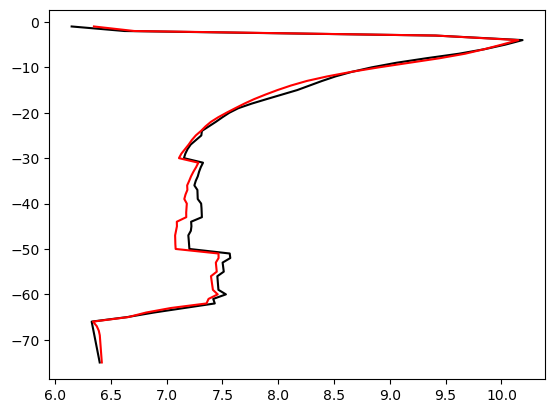

In [63]:
plt.plot(np.nanmean(profile_set['ys']['MAM']['obs'],axis=1),depth_intplevel,'k')
plt.plot(np.nanmean(profile_set['ys']['MAM']['post'],axis=1),depth_intplevel,'r')
plt.show()

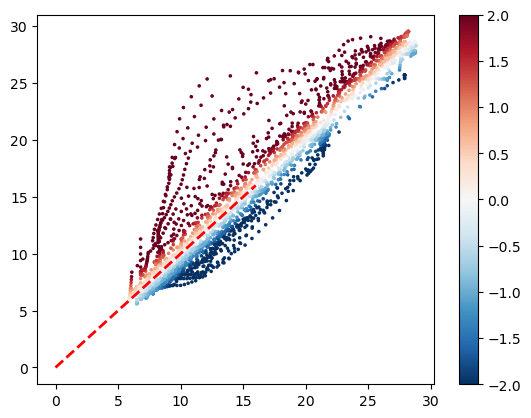

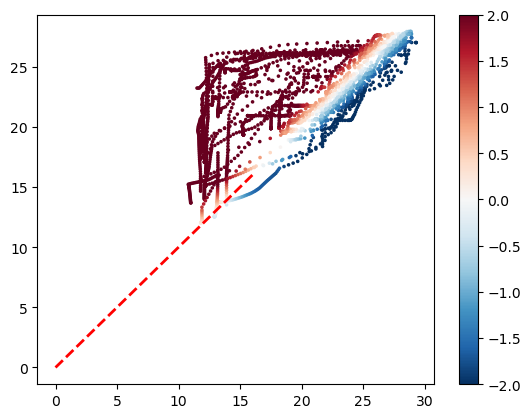

In [59]:
plt.plot(np.arange(0,17),np.arange(0,17),'r--',linewidth = 2,)
plt.scatter(profile_set['cre']['JJA']['obs'],profile_set['cre']['JJA']['fwd'],10,profile_set['cre']['JJA']['fwd_error'],marker='.',cmap='RdBu_r',vmin=-2,vmax=2)
# plt.ylim([0,16])
# plt.xlim([0,16])
plt.colorbar()

In [377]:
iseason

'SON'

MAM
JJA
SON
DJF


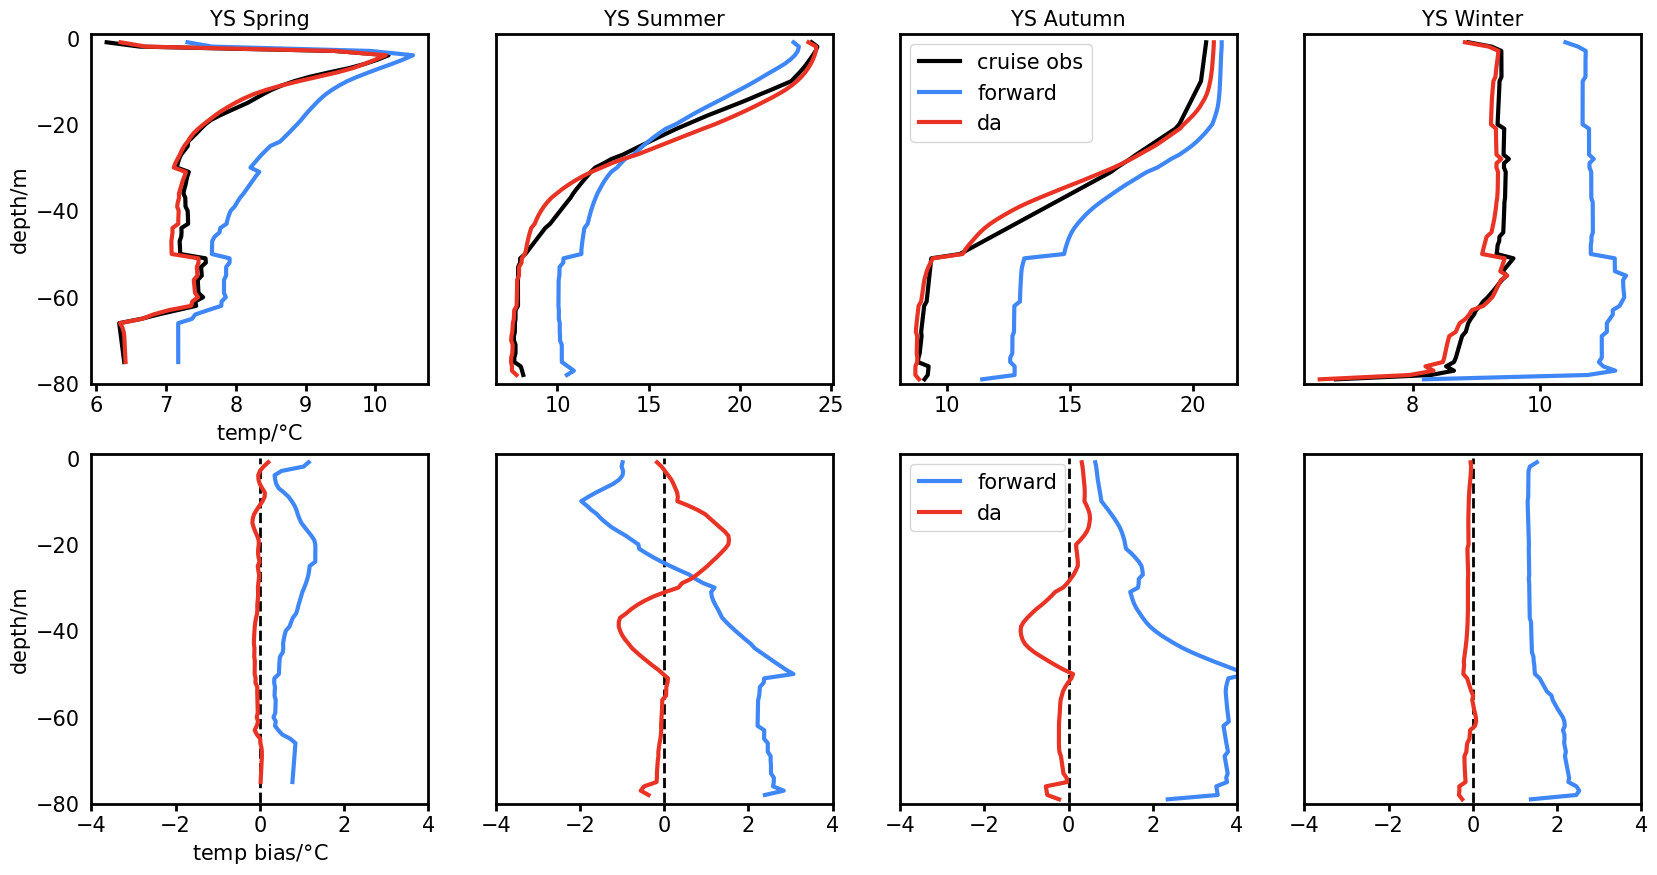

In [118]:
plt.style.use('default')
area = 'ys'
fig,axs = plt.subplots(ncols=4, nrows=2, figsize = (20,10),)
season_name = ['Spring','Summer','Autumn','Winter']
depth_intplevel = np.arange(-200,1,1)
for i,iseason in enumerate(season):
    print(iseason)
    for bnd in axs[0][i].spines.keys():
        axs[0][i].spines[bnd].set_linewidth('2')
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['obs'],axis=1),depth_intplevel,color='k', linewidth=3,label='cruise obs',zorder=2)
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['fwd'],axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='forward',zorder=2)
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['post'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='da',zorder=2)
    # axs[0][i].plot(np.nanmean(profile_set[area][iseason]['prior'],axis=1),depth_intplevel,color=my_palette[7], linewidth=3,label='da_sst ',zorder=2)
    # ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
    # ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
    # axs[0][i].plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
    # ax.set_xlim([-3,3])
    axs[0][i].set_ylim([-80,1])
    
    
    
    axs[0][i].tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
    if i>=1:
        axs[0][i].tick_params('y',labelleft=False)
    elif i ==0:
        axs[0][i].set_ylabel('depth/m',fontsize=15)
        axs[0][i].set_xlabel('temp/$\degree$C',fontsize=15)
        
    if i == 2:
        axs[0][i].legend(loc='upper left',fontsize=15)
    axs[0][i].set_title(area.upper() + ' ' + season_name[i],fontsize=15)
    # plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)
for i,iseason in enumerate(season):
    for bnd in axs[1][i].spines.keys():
        axs[1][i].spines[bnd].set_linewidth('2')
    # ax.plot(np.nanmean(profile_set['ys']['DJF']['obs'],axis=1),depth_intplevel,color='k', linewidth=3,label='Cruise Observation',zorder=2)
    axs[1][i].plot(np.nanmean(profile_set[area][iseason]['fwd_error'],axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='forward',zorder=2)
    axs[1][i].plot(np.nanmean(profile_set[area][iseason]['post_error'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='da',zorder=2)
    # axs[1][i].plot(np.nanmean(profile_set[area][iseason]['prior_error'],axis=1),depth_intplevel,color=my_palette[7], linewidth=3,label='da_sst',zorder=2)
    # axs[1][i].plot(np.nanstd(profile_set['ys'][iseason]['fwd_error'],axis=1),depth_intplevel,'--',color=my_palette[0], linewidth=3,label='error std',zorder=2)
    # axs[1][i].plot(np.sqrt(np.nanstd(profile_set['ys'][iseason]['fwd_error'],axis=1)**2 +np.nanmean(profile_set['ys'][iseason]['fwd_error'],axis=1)**2),depth_intplevel,'-.',color=my_palette[0], linewidth=3,label='rmse',zorder=2)
    # axs[1][i].plot(np.nanmean(profile_set['ys'][iseason]['post_error'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='DA_SST ',zorder=2)
    # ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
    # ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
    axs[1][i].plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
    axs[1][i].set_xlim([-4,4])
    axs[1][i].set_ylim([-80,1])
    # axs[1][i].legend(loc='upper left',fontsize=15)

    
    axs[1][i].tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
    if i>=1:
        axs[1][i].tick_params('y',labelleft=False)
    elif i ==0:
        axs[1][i].set_ylabel('depth/m',fontsize=15)
        axs[1][i].set_xlabel('temp bias/$\degree$C',fontsize=15)
    if i == 2:
        axs[1][i].legend(loc='upper left',fontsize=15)
    plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_analysis/validation/fig_profile_post/%s/da_bias.jpeg'%(area),bbox_inches='tight',dpi=400)

In [98]:
obs_all.shape


(91455,)

In [121]:
coef_fwd[0]

0.85765631137684

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


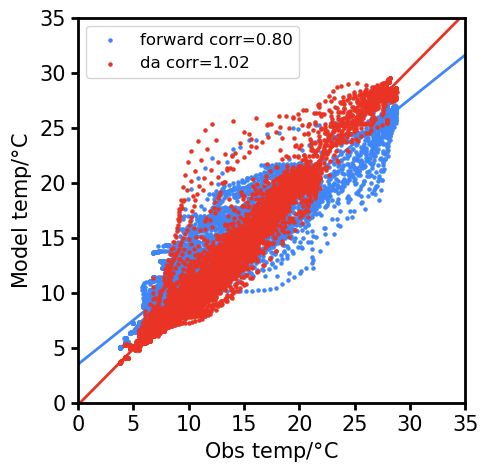

In [126]:
plt.style.use('default')
area = 'ys'
fig,ax = plt.subplots(figsize = (5,5),)
for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0)
season_name = ['Spring','Summer','Autumn','Winter']
depth_intplevel = np.arange(-200,1,1)

for i, iarea in enumerate(['ys']):
    for j,iseason in enumerate(season):
        if i==0 and j ==0:
            obs_all = profile_set[iarea][iseason]['obs'].ravel()
            fwd_all = profile_set[iarea][iseason]['fwd'].ravel()
            
        else:
            
            obs_all = np.r_[obs_all,profile_set[iarea][iseason]['obs'].ravel()]
            fwd_all = np.r_[fwd_all,profile_set[iarea][iseason]['fwd'].ravel()]

for i, iarea in enumerate(['ys']):
    for j,iseason in enumerate(season):
        if i==0 and j ==0:
            post_all = profile_set[iarea][iseason]['post'].ravel()
        else:
            post_all = np.r_[post_all,profile_set[iarea][iseason]['post'].ravel()]


coef_fwd = np.polyfit(obs_all[~np.isnan(obs_all)],fwd_all[~np.isnan(obs_all)],1)
coef_da = np.polyfit(obs_all[~np.isnan(obs_all)],post_all[~np.isnan(obs_all)],1)
x = np.arange(36)
fit_fwd = np.polyval(coef_fwd,x)
fit_da = np.polyval(coef_da,x)
ax.plot(x,fit_fwd,linewidth = 2, color = my_palette[0],zorder=1)
ax.plot(x,fit_da,linewidth = 2, color = my_palette[-1],zorder=2)
ax.scatter(obs_all,fwd_all,5,my_palette[0],marker='o',label='forward corr=%.2f'%(coef_fwd[0]),zorder=1)
ax.scatter(obs_all,post_all,5,my_palette[-1],marker='o',label='da corr=%.2f'%(coef_da[0]),zorder=2)
ax.set_ylabel('Model temp/$\degree$C',fontsize=15)
ax.set_xlabel('Obs temp/$\degree$C',fontsize=15)
ax.set_ylim([0,35])
ax.set_yticks(np.arange(0,36,5))
ax.set_xlim([0,35])
ax.set_xticks(np.arange(0,36,5))
ax.legend(fontsize=12)
plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_analysis/validation/fig_profile_post/%s/dasst_bias.jpeg'%(area),bbox_inches='tight',dpi=400)

Text(0.5, 1.0, 'Cruise Observation')

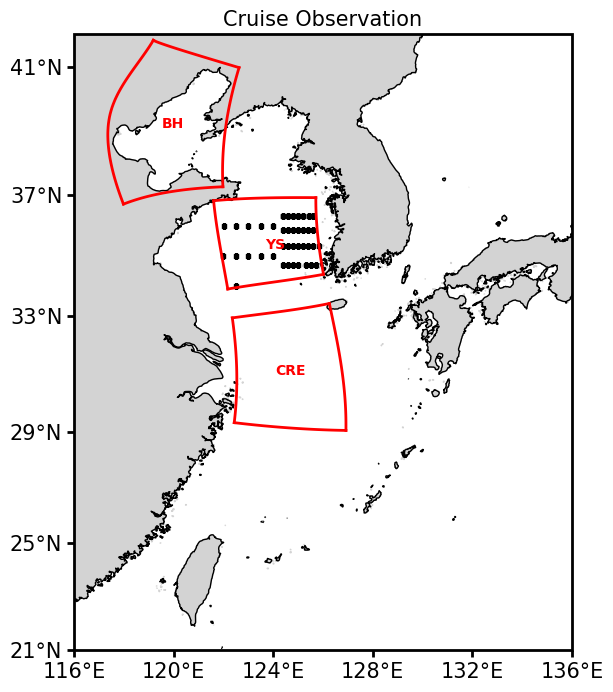

In [356]:
# %matplotlib

plt.style.use('default')
lon_bdy = [116,136];
lat_bdy = [21,42];
plt.rcParams['font.family'] = 'sans-serif'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'k',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.scatter(profile_set['ys']['MAM']['obs_lon'],profile_set['ys']['MAM']['obs_lat'],10,'k',marker='s',transform = ccrs.PlateCarree(),)
for iarea in ['bh','cre','ys']:
    if iarea == 'bh':
        abbrname = 'BH'
    elif iarea == 'ys':
        abbrname = 'YS'
    elif iarea =='cre':
        abbrname = 'CRE'
    lon_area = fwd_ds.lon_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).data.compute()
    lat_area = fwd_ds.lat_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).data.compute()

    ax.plot(lon_area[:,0], lat_area[:,0], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[:,-1], lat_area[:,-1], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[-1,:], lat_area[-1,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[0,:], lat_area[0,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.text(0.5*(lon_area[0,0]+lon_area[0,-1]),
            0.5*(lat_area[0,0]+lat_area[-1,0]),abbrname, 
            verticalalignment='center', horizontalalignment='center',
            color = 'r',fontweight='bold',
            transform=ccrs.PlateCarree(),zorder = 3)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0)
ax.set_title('Cruise Observation',fontsize=15)
# plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/obs_pos.jpeg',bbox_inches='tight',dpi=400)

In [537]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2013-06-25-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 7
# 2d situation
model_var = 'salt' 
#3d situation
# model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))




duration to be validated: from 2012-05-01-12H to 2013-06-25-12H, total of 421 days.
         target obs variable: 7
         target model variable: salt


In [538]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 200)&
                                (Obs_ds.obs_type == obs_var)
                        )

Obs_ds_thisrange = Obs_ds.isel(datum=this_range[0]).copy()
Obs_time = Obs_ds_thisrange.obs_time.data[:]
Obs_data = Obs_ds_thisrange.obs_value.data[:]
Obs_depth = Obs_ds_thisrange.obs_depth.data[:]
Obs_lon = Obs_ds_thisrange.obs_lon.data[:]
Obs_lat = Obs_ds_thisrange.obs_lat.data[:]
Obs_x = Obs_ds_thisrange.obs_Xgrid.data[:]
Obs_y = Obs_ds_thisrange.obs_Ygrid.data[:]
# Obs_data = Obs_data
# Obs_data


In [542]:
def ll_unique(obs_time,obs_lon,obs_lat,obs_data):
    ip = 0
    for iobstime in np.unique(obs_time):
        thistime = np.where(obs_time == iobstime)



        for ipos in np.array(list(set(tuple(zip(np.round(obs_lon[thistime],8),np.round(obs_lat[thistime],8)))))):
            # print(ipos)
            thispos = np.where( (np.round(obs_lon[thistime],8)==ipos[0]) & (np.round(obs_lat[thistime],8)==ipos[1]))


            obs_profile = obs_data[thistime][thispos]

            lon_thispos = ipos[0]

            lat_thispos = ipos[1]
            if ip == 0:
                lon_obs = ipos[0]
                lat_obs = ipos[1]
            else:
                lon_obs = np.r_[lon_obs,ipos[0]]
                lat_obs = np.c_[lat_obs,ipos[1]]
            ip+=1
    return lon_obs, lat_obs

def obs_intp2mod(grd_file,dataset,ds_time,obs_data,obs_time,obs_lon,obs_lat,obs_x,obs_y,obs_depth,figpath):
    ip = 0
    for iobstime in np.unique(obs_time):
        thistime = np.where(obs_time == iobstime)
        # print('OBS TIME:',(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
        ds_tindex = np.argmin(np.abs(ds_time-iobstime))
        # da_tindex = np.argmin(np.abs(prior_time-iobstime))

        data_thistime = dataset[model_var].isel(ocean_time=ds_tindex).data.compute()
        # print('dataset TIME:',(dt.timedelta(ds_time[ds_tindex])+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'))
        zeta_thistime = dataset['zeta'].isel(ocean_time=ds_tindex).data.compute()



        grid = seapy.model.asgrid(grd_file); grid.zeta = zeta_thistime;grid = seapy.model.asgrid(grid)
    #     priorgrid = seapy.model.asgrid(grd_file); priorgrid.zeta = priorzeta_thistime;priorgrid = seapy.model.asgrid(priorgrid)
    #     postgrid = seapy.model.asgrid(grd_file); postgrid.zeta = postzeta_thistime;postgrid = seapy.model.asgrid(postgrid)

        for ipos in np.array(list(set(tuple(zip(np.round(obs_lon[thistime],8),np.round(obs_lat[thistime],8)))))):
            # print(ipos)
            thispos = np.where( (np.round(obs_lon[thistime],8)==ipos[0]) & (np.round(obs_lat[thistime],8)==ipos[1]))


            obs_profile =obs_data[thistime][thispos]
            x_thispos = int(np.round(obs_x[thistime][thispos][0]))
            lon_thispos = ipos[0]
            # print(x_thispos,lon_thispos)
            y_thispos = int(np.round(obs_y[thistime][thispos][0]))
            lat_thispos = ipos[1]
            # print(y_thispos,lat_thispos)
            depth_intplevel = np.arange(-200,1,1)
            obs_intplevel = np.interp(depth_intplevel,obs_depth[thistime][thispos],obs_profile,left=np.nan,right=np.nan)

            # print('\tOBS POS:', 'LON:', lon_thispos, 'LAT:', lat_thispos)

            # print('\tMOD POS:', 'LON:',dataset.lon_rho.data.compute()[y_thispos,x_thispos],
                              # 'LAT:',dataset.lat_rho.data.compute()[y_thispos,x_thispos])
            # print('\tMOD POS:', 'X:  ', x_thispos, 'Y:  ', y_thispos)


            data_intplevel = np.interp(depth_intplevel,grid.depth_rho[:,y_thispos,x_thispos],data_thistime[:,y_thispos,x_thispos],left=np.nan,right=np.nan)
            obs_intplevel[depth_intplevel<np.maximum(np.nanmin(obs_depth[thistime][thispos]), np.nanmin(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            data_intplevel[depth_intplevel<np.maximum(np.nanmin(obs_depth[thistime][thispos]), np.nanmin(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            obs_intplevel[depth_intplevel>np.minimum(np.nanmax(obs_depth[thistime][thispos]), np.nanmax(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            data_intplevel[depth_intplevel>np.minimum(np.nanmax(obs_depth[thistime][thispos]), np.nanmax(grid.depth_rho[:,y_thispos,x_thispos]))] = np.nan
            if ip == 0:
                obs_profiles = obs_intplevel.copy()
                data_profiles = data_intplevel.copy()

                data_errs = data_intplevel - obs_intplevel

            else:
                obs_profiles = np.c_[obs_profiles,obs_intplevel.copy()]
                data_profiles = np.c_[data_profiles,data_intplevel.copy()]

                data_errs = np.c_[data_errs,data_intplevel - obs_intplevel]


            ip+=1
            fig,ax = plt.subplots(figsize = (4,8))
    
            ax.plot(obs_profile,obs_depth[thistime][thispos],'o-',color='k',label='cruise obs')
            # ax.plot(fwd_profile[1:],depth_modlevel[1:],color=my_palette[-1], label='forward',)
            ax.plot(data_intplevel,depth_intplevel,'.-',color=my_palette[0], label='mod',)


            # ax.plot(prior_profile[1:],depth_modlevel[1:],color=my_palette[7],label='prior',)
            # ax.plot(prior_intplevel,depth_intplevel,'.-',color=my_palette[7],label='DA_SST ROMSv4.1',)
            # ax.plot(post_profile[1:],depth_modlevel[1:],color=my_palette[0],label='posterior',)
            # ax.plot(post_intplevel,depth_intplevel,'.-',color=my_palette[-1],label='DA_ALL ROMSv4.1',)
            ax.legend(loc='upper left',fontsize=12)
            ax.set_ylabel('depth/m')
            ax.set_xlabel('salt/PSU')
            ax.set_title('OBS TIME = %s \n LON: %s LAT: %s'%((dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M'),
                                                    np.round(lon_thispos,2),
                                                    np.round(lat_thispos,2)))
            plt.savefig('./%s/%s_saltprofile.jpeg'%(figpath,(dt.timedelta(iobstime)+dt.datetime(1970,1,1)).strftime('%Y-%m-%d %H_%M')),bbox_inches='tight',dpi=400)
        plt.close()
        del data_thistime
        del zeta_thistime

        del grid
        gc.collect()
        
    return obs_profiles, data_profiles, data_errs

In [543]:
for iarea in ['ys','cre']:
    # iarea = 'ys'
    print('area: %s'%(iarea))
    lon_rho_area = fwd_ds.lon_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                     xi_rho=area_range[iarea]['xi_range']).data.compute()
    lat_rho_area = fwd_ds.lat_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                     xi_rho=area_range[iarea]['xi_range']).data.compute()

    Xbox_area = np.r_[lon_rho_area[0,:],
                 lon_rho_area[1:,-1],
                 np.flip(lon_rho_area[-1,:-1]),
                 np.flip(lon_rho_area[:-1,0])]
    Ybox_area = np.r_[lat_rho_area[0,:],
                 lat_rho_area[1:,-1],
                 np.flip(lat_rho_area[-1,:-1]),
                 np.flip(lat_rho_area[:-1,0])]
    box_area = [(x,y) for x,y in zip(Xbox_area,Ybox_area)]
    polygon = path.Path(box_area)
    withinarea = polygon.contains_points([(obsx,obsy) for obsx,obsy in zip(Obs_lon,Obs_lat)])
    index_area = np.where(withinarea)
    Obs_ds_area = Obs_ds_thisrange.isel(datum=withinarea)

    Obs_ds_area =Obs_ds_area.assign_coords(datum=[ dt.timedelta(itime)+dt.datetime(1970,1,1) for itime in Obs_ds_area.obs_time.data ])

    Obs_ds_as = Obs_ds_area.groupby('datum.season') # as: area season 
    season = ['MAM',  'JJA', 'SON','DJF',]
    for i, iseason in enumerate(season):
        print('season: %s'%(iseason))
        Obs_time_tats = Obs_ds_as[iseason].obs_time.data[:]  # tats :this area this season 
        Obs_data_tats = Obs_ds_as[iseason].obs_value.data[:]
        Obs_depth_tats = Obs_ds_as[iseason].obs_depth.data[:]
        Obs_lon_tats = Obs_ds_as[iseason].obs_lon.data[:]
        Obs_lat_tats = Obs_ds_as[iseason].obs_lat.data[:]
        Obs_x_tats = Obs_ds_as[iseason].obs_Xgrid.data[:]
        Obs_y_tats = Obs_ds_as[iseason].obs_Ygrid.data[:]


        lon_obs_tats, lat_obs_tats = ll_unique(Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_data_tats)

        obs_profile_tats, fwd_profile_tats, fwd_err_tats = obs_intp2mod(grd_file,fwd_ds,fwd_time,
                                                                       Obs_data_tats,Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_x_tats, Obs_y_tats, Obs_depth_tats,
                                                                       'fig_profile_fwd/%s/%s'%(iarea,iseason))
        obs_profile_tats, post_profile_tats, post_err_tats = obs_intp2mod(grd_file,post_ds,post_time,
                                                                       Obs_data_tats,Obs_time_tats, Obs_lon_tats, Obs_lat_tats, Obs_x_tats, Obs_y_tats, Obs_depth_tats,
                                                                       'fig_profile_post/%s/%s'%(iarea,iseason))
        profile_set[iarea][iseason]['lon_obs'] = lon_obs_tats
        profile_set[iarea][iseason]['lon_obs'] = lat_obs_tats
        profile_set[iarea][iseason]['obs'] = obs_profile_tats
        profile_set[iarea][iseason]['fwd'] = fwd_profile_tats
        profile_set[iarea][iseason]['fwd_error'] = fwd_err_tats
        profile_set[iarea][iseason]['post'] = post_profile_tats
        profile_set[iarea][iseason]['post_error'] = post_err_tats


area: ys
season: MAM
season: JJA
season: SON
season: DJF
area: cre
season: MAM
season: JJA
season: SON
season: DJF


MAM


NameError: name 'ax' is not defined

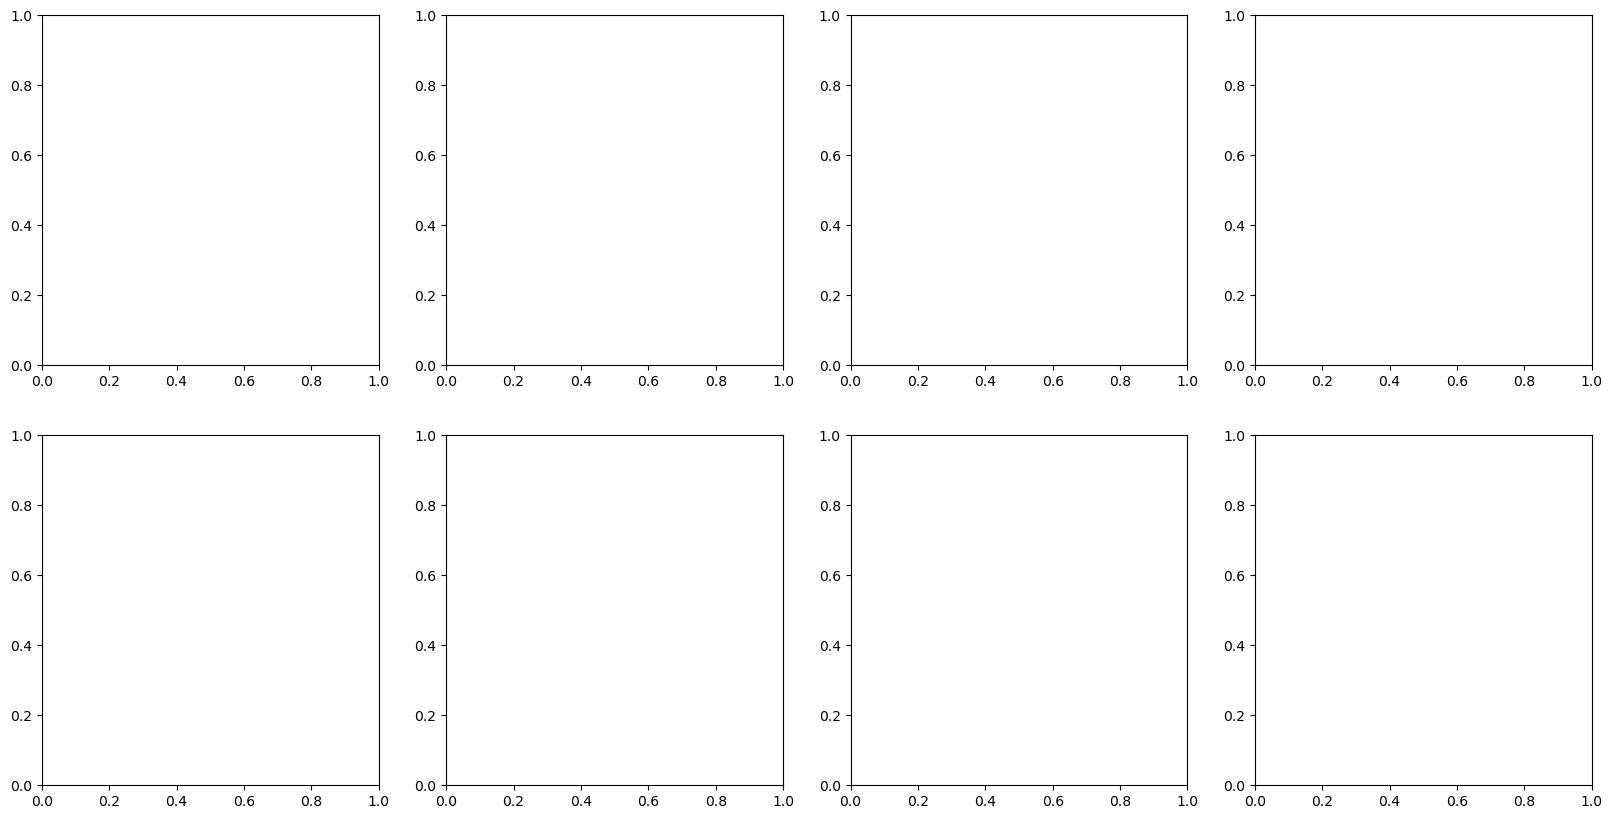

In [23]:
plt.style.use('default')
area = 'ys'
fig,axs = plt.subplots(ncols=4, nrows=2, figsize = (20,10),)
season_name = ['Spring','Summer','Autumn','Winter']
for i,iseason in enumerate(season):
    print(iseason)
    for bnd in ax.spines.keys():
        axs[0,i].spines[bnd].set_linewidth('2')
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['obs'],axis=1),depth_intplevel,color='k', linewidth=3,label='cruise obs',zorder=2)
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['fwd'],axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='forward',zorder=2)
    axs[0][i].plot(np.nanmean(profile_set[area][iseason]['post'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='da_sst ',zorder=2)
    # ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
    # ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
    # axs[0][i].plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
    # ax.set_xlim([-3,3])
    axs[0][i].set_ylim([-80,1])
    
    
    
    axs[0][i].tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
    if i>=1:
        axs[0][i].tick_params('y',labelleft=False)
    elif i ==0:
        axs[0][i].set_ylabel('depth/m',fontsize=15)
        axs[0][i].set_xlabel('salt/PSU',fontsize=15)
        
    if i == 2:
        axs[0][i].legend(loc='upper left',fontsize=15)
    axs[0][i].set_title(area.upper() + ' ' + season_name[i],fontsize=15)
    # plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/dasst_bias.jpeg',bbox_inches='tight',dpi=400)
for i,iseason in enumerate(season):
    for bnd in ax.spines.keys():
        axs[1][i].spines[bnd].set_linewidth('2')
    # ax.plot(np.nanmean(profile_set['ys']['DJF']['obs'],axis=1),depth_intplevel,color='k', linewidth=3,label='Cruise Observation',zorder=2)
    axs[1][i].plot(np.nanmean(profile_set[area][iseason]['fwd_error'],axis=1),depth_intplevel,color=my_palette[0], linewidth=3,label='forward',zorder=2)
    axs[1][i].plot(np.nanmean(profile_set[area][iseason]['post_error'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='da_sst',zorder=2)
    # axs[1][i].plot(np.sqrt(np.nanstd(profile_set['ys'][iseason]['fwd_error'],axis=1)**2 +np.nanmean(profile_set['ys'][iseason]['fwd_error'],axis=1)**2),depth_intplevel,'-.',color=my_palette[0], linewidth=3,label='rmse',zorder=2)
    # axs[1][i].plot(np.nanmean(profile_set['ys'][iseason]['post_error'],axis=1),depth_intplevel,color=my_palette[-1], linewidth=3,label='DA_SST ',zorder=2)
    # ax.plot(np.nanmean(Prior_errs,axis=1),depth_intplevel,color=my_palette[7],linewidth=3,label='DA_SST ROMS v3.7',zorder=2)
    # ax.plot(np.nanmean(Post_errs,axis=1),depth_intplevel,color=my_palette[-1],linewidth=3,label='DA_ALL ROMS v4.1',zorder=2)
    axs[1][i].plot(np.zeros_like(depth_intplevel),depth_intplevel,'--',color='k',linewidth=2,zorder=1)
    axs[1][i].set_xlim([-2,2])
    axs[1][i].set_ylim([-80,1])
    # axs[1][i].legend(loc='upper left',fontsize=15)

    
    axs[1][i].tick_params(direction = 'out',width =2,length=5, labelsize = 15,top = 0, right = 0,left=0)
    if i>=1:
        axs[1][i].tick_params('y',labelleft=False)
    elif i ==0:
        axs[1][i].set_ylabel('depth/m',fontsize=15)
        axs[1][i].set_xlabel('salt/PSU',fontsize=15)
    if i == 2:
        axs[1][i].legend(loc='upper left',fontsize=15)
    plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_analysis/validation/fig_profile_post/%s/dasst_saltbias.jpeg'%(area),bbox_inches='tight',dpi=400)